<a href="https://colab.research.google.com/github/subhashpolisetti/timegpt-tabula-rdl-forecasting/blob/main/Price_Classification_Prediction_Using_Tabula_Model_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Data Generation and Model Inference Using Tabula and PyTorch

This Colab notebook demonstrates how to use the **Tabula** model for generating synthetic data based on real-world examples, training a machine learning model using this synthetic data, and performing inference tasks. The notebook covers the installation of required libraries, data preprocessing, model training, and prediction tasks.

## Key Libraries and Installation

1. **PyTorch**: A deep learning library used for building models.
   - We install the latest version of **PyTorch** (with CUDA support for GPU acceleration).
   
2. **Tabula**: A tool for generating synthetic data, especially designed for tabular datasets.
   - `torch-geometric` and other related libraries are installed for working with graph-based data (optional setup).

3. **Hugging Face Transformers**: The model and tokenizer are used for loading pre-trained models (such as **LlamaForCausalLM**) to perform text generation tasks.

4. **rtfm**: A toolkit for training and inference with language models, specifically designed for synthetic data generation.

## Dataset and Data Preprocessing

We load a real-world **Insurance** dataset and pre-process it by performing the following steps:

- **Data Import**: Import the dataset into pandas for manipulation.
- **Feature Preprocessing**: Prepare the dataset by discretizing continuous columns like `price` into different categories (buckets).

```python
import pandas as pd
import torch
from transformers import AutoTokenizer, LlamaForCausalLM, AutoConfig
from rtfm.configs import TrainConfig, TokenizerConfig
from rtfm.inference_utils import InferenceModel
from rtfm.serialization.serializers import get_serializer
from rtfm.tokenization.text import prepare_tokenizer


In [ ]:
# Install PyTorch 2.0.0 with CUDA 11.7 support, torchvision, and torchaudio
# This is necessary for GPU-accelerated deep learning and computer vision tasks.

pip install torch==2.0.0+cu117 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 35.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 63.5 MB/s eta 0:00:00
  Created wheel for lit: filename=lit-15.0.7-py3

In [ ]:
# Install PyTorch Geometric and related dependencies
# These libraries provide functions for working with graph data, which is essential for graph neural networks (GNNs) and other graph-based machine learning tasks.

pip install torch-geometric torch-sparse torch-scatter torch-cluster torch-spline-conv pyg-lib -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [ ]:
# Optional setup; use if the notebook is not running inside the rtfm conda environment.
# This will clone the rtfm repository from GitHub and install the necessary dependencies.
!git clone https://github.com/mlfoundations/rtfm.git

# Change the working directory to the cloned rtfm directory
%cd rtfm

# Ensure pip is up to date to avoid potential issues with package installations
!pip install --upgrade pip

# Install Python 3.8 using pip, which is required for compatibility with certain packages
!pip install python==3.8

# Install the dependencies listed in the requirements.txt file
# This file includes all the Python packages required for the rtfm project
!pip install -r requirements.txt

# Install additional dependencies directly from GitHub repositories
# These are libraries or custom packages that are not available via PyPI
!pip install git+https://github.com/jpgard/llama-recipes.git

# Install the current rtfm directory as a Python package
# This installs the code from the local repository into your environment
!pip install -e .

# Install another package directly from GitHub without dependencies
# The '--no-deps' flag ensures that pip does not install the dependencies that may already be satisfied in your environment
!pip install --no-deps git+https://github.com/mlfoundations/tableshift.git


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, LlamaForCausalLM, AutoConfig

# Import relevant utilities from the rtfm package for training configuration, model inference, serialization, and tokenization
from rtfm.configs import TrainConfig, TokenizerConfig
from rtfm.inference_utils import InferenceModel
from rtfm.serialization.serializers import get_serializer
from rtfm.tokenization.text import prepare_tokenizer

# Define the configuration for the training, specifying the model and context length
train_config = TrainConfig(model_name="mlfoundations/tabula-8b", context_length=8192)

# Configure tokenizer settings
# If using a base Llama model (not fine-tuned with TabuLa), set `add_serializer_tokens=False`
# This ensures no special tokens are added as the base model was not trained on them.
tokenizer_config = TokenizerConfig()

# Load the model configuration from the pre-trained model specified in train_config
config = AutoConfig.from_pretrained(train_config.model_name)

# Set the torch_dtype to bfloat16 for compatibility with the TabuLa training and evaluation setup
config.torch_dtype = 'bfloat16'

# Determine the device to use (CUDA for GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the LlamaForCausalLM model using the pre-trained weights and the custom configuration
# The model will be loaded to the appropriate device (CPU or GPU)
model = LlamaForCausalLM.from_pretrained(
    train_config.model_name, device_map="auto", config=config).to(device)

# Load the tokenizer associated with the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(train_config.model_name)

# Get the appropriate serializer for the model configuration
serializer = get_serializer(train_config.serializer_cls)

# Prepare the tokenizer and model, ensuring they are properly configured for text generation tasks
tokenizer, model = prepare_tokenizer(
    model,
    tokenizer=tokenizer,
    pretrained_model_name_or_path=train_config.model_name,
    model_max_length=train_config.context_length,
    use_fast_tokenizer=tokenizer_config.use_fast_tokenizer,
    serializer_tokens_embed_fn=tokenizer_config.serializer_tokens_embed_fn,
    serializer_tokens=serializer.special_tokens if tokenizer_config.add_serializer_tokens else None,
)

# Create an InferenceModel that combines the model, tokenizer, and serializer for inference
inference_model = InferenceModel(model=model, tokenizer=tokenizer, serializer=serializer)


read user yaml files: 0it [00:00, ?it/s]
/gscratch/efml/jpgard/miniconda3/envs/rtfm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Importing necessary libraries
import pandas as pd

# Defining labeled examples (sample data) representing the weather for various cities
labeled_examples = pd.DataFrame(
    [
        {"location": "New York", "temperature": 22, "humidity": 65, "wind_speed": 12, "pressure": 1012, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Partly Sunny"},
        {"location": "Los Angeles", "temperature": 26, "humidity": 60, "wind_speed": 7, "pressure": 1015,
         "month": "July", "weather_yesterday": "Partly Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
        {"location": "Chicago", "temperature": 18, "humidity": 70, "wind_speed": 15, "pressure": 1008, "month": "July",
         "weather_yesterday": "Partly Cloudy", "precipitation": 0.1, "visibility": 8, "weather_today": "Cloudy"},
        {"location": "Houston", "temperature": 30, "humidity": 80, "wind_speed": 10, "pressure": 1010, "month": "July",
         "weather_yesterday": "Rain", "precipitation": 0.5, "visibility": 7, "weather_today": "Rain"},
        {"location": "Phoenix", "temperature": 35, "humidity": 20, "wind_speed": 5, "pressure": 1005, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
        {"location": "Philadelphia", "temperature": 24, "humidity": 75, "wind_speed": 14, "pressure": 1009,
         "month": "July", "weather_yesterday": "Partly Cloudy", "precipitation": 0.2, "visibility": 9,
         "weather_today": "Partly Cloudy"},
        {"location": "San Antonio", "temperature": 28, "humidity": 68, "wind_speed": 11, "pressure": 1011,
         "month": "July", "weather_yesterday": "Rain", "precipitation": 0.4, "visibility": 8, "weather_today": "Rain"},
        {"location": "San Diego", "temperature": 22, "humidity": 65, "wind_speed": 10, "pressure": 1014,
         "month": "July", "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Partly Sunny"},
        {"location": "Dallas", "temperature": 27, "humidity": 72, "wind_speed": 9, "pressure": 1007, "month": "July",
         "weather_yesterday": "Partly Cloudy", "precipitation": 0.3, "visibility": 9, "weather_today": "Cloudy"},
    ]
)

# Defining the target example for which we need a prediction
target_example = pd.DataFrame(
    [
        {"location": "San Jose", "temperature": 23, "humidity": 55, "wind_speed": 8, "pressure": 1013, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
    ]
)

# Making a prediction using the inference model
output = inference_model.predict(
    target_example=target_example,  # The example we want to make a prediction for
    target_colname="weather_today",  # The column we are predicting (weather today)
    target_choices=["Sunny", "Partly Sunny", "Cloudy", "Partly Cloudy", "Rain"],  # Possible weather outcomes
    labeled_examples=labeled_examples,  # The labeled data to train the model
)

# Printing the prediction result
print(f"Prediction for sample \n {target_example} \n is: {output}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prediction for sample 
    location  temperature  humidity  wind_speed  pressure month  \
0  San Jose           23        55           8      1013  July   

  weather_yesterday  precipitation  visibility weather_today  
0             Sunny              0          10         Sunny   
 is: Sunny


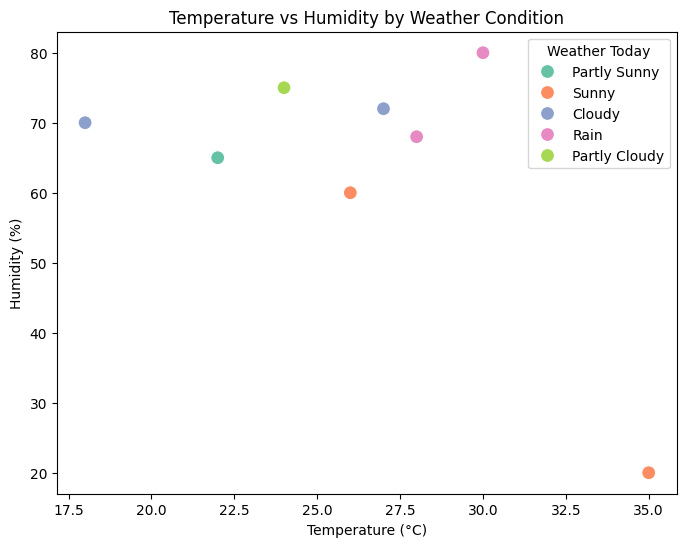

<ipython-input-5-5e07a8f93ec9>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labeled_examples, x="weather_today", palette="Set1")


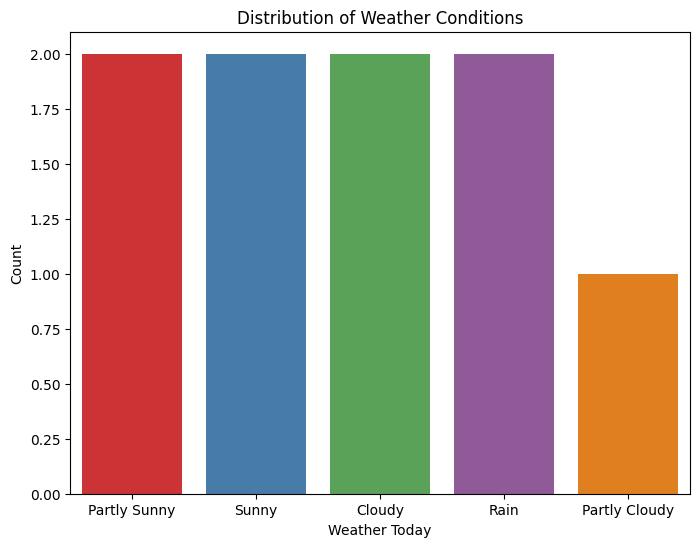

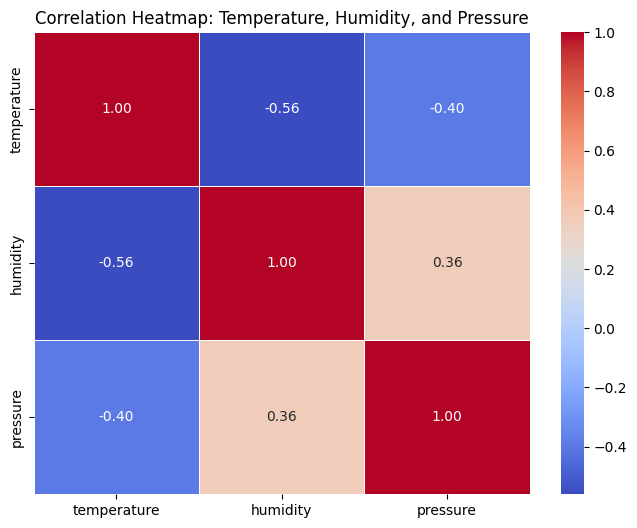

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labeled_examples = pd.DataFrame(
    [
        {"location": "New York", "temperature": 22, "humidity": 65, "wind_speed": 12, "pressure": 1012, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Partly Sunny"},
        {"location": "Los Angeles", "temperature": 26, "humidity": 60, "wind_speed": 7, "pressure": 1015,
         "month": "July", "weather_yesterday": "Partly Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
        {"location": "Chicago", "temperature": 18, "humidity": 70, "wind_speed": 15, "pressure": 1008, "month": "July",
         "weather_yesterday": "Partly Cloudy", "precipitation": 0.1, "visibility": 8, "weather_today": "Cloudy"},
        {"location": "Houston", "temperature": 30, "humidity": 80, "wind_speed": 10, "pressure": 1010, "month": "July",
         "weather_yesterday": "Rain", "precipitation": 0.5, "visibility": 7, "weather_today": "Rain"},
        {"location": "Phoenix", "temperature": 35, "humidity": 20, "wind_speed": 5, "pressure": 1005, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
        {"location": "Philadelphia", "temperature": 24, "humidity": 75, "wind_speed": 14, "pressure": 1009,
         "month": "July", "weather_yesterday": "Partly Cloudy", "precipitation": 0.2, "visibility": 9,
         "weather_today": "Partly Cloudy"},
        {"location": "San Antonio", "temperature": 28, "humidity": 68, "wind_speed": 11, "pressure": 1011,
         "month": "July", "weather_yesterday": "Rain", "precipitation": 0.4, "visibility": 8, "weather_today": "Rain"},
        {"location": "San Diego", "temperature": 22, "humidity": 65, "wind_speed": 10, "pressure": 1014,
         "month": "July", "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Partly Sunny"},
        {"location": "Dallas", "temperature": 27, "humidity": 72, "wind_speed": 9, "pressure": 1007, "month": "July",
         "weather_yesterday": "Partly Cloudy", "precipitation": 0.3, "visibility": 9, "weather_today": "Cloudy"},
    ]
)

# Defining the target example for which we need a prediction
target_example = pd.DataFrame(
    [
        {"location": "San Jose", "temperature": 23, "humidity": 55, "wind_speed": 8, "pressure": 1013, "month": "July",
         "weather_yesterday": "Sunny", "precipitation": 0, "visibility": 10, "weather_today": "Sunny"},
    ]
)

# Visualization 1: Scatter plot of temperature vs. humidity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=labeled_examples, x="temperature", y="humidity", hue="weather_today", palette="Set2", s=100)
plt.title("Temperature vs Humidity by Weather Condition")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.legend(title='Weather Today')
plt.show()

# Visualization 2: Distribution of weather conditions in the labeled data
plt.figure(figsize=(8, 6))
sns.countplot(data=labeled_examples, x="weather_today", palette="Set1")
plt.title("Distribution of Weather Conditions")
plt.xlabel("Weather Today")
plt.ylabel("Count")
plt.show()

# Visualization 3: Correlation heatmap between temperature, humidity, and pressure
correlation_matrix = labeled_examples[["temperature", "humidity", "pressure"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Temperature, Humidity, and Pressure")
plt.show()



In [ ]:
# Importing necessary function for discretizing continuous columns
from rtfm.serialization.serialization_utils import discretize_continuous_column

# Creating a DataFrame with housing data, including features like location, size, number of bedrooms, price, etc.
examples = pd.DataFrame(
    [
        {"location": "New York", "size_sqft": 1200, "bedrooms": 3, "bathrooms": 2, "age": 10, "lot_size_acres": 0.15, "garage": True, "price": 850},
        {"location": "Los Angeles", "size_sqft": 1500, "bedrooms": 4, "bathrooms": 3, "age": 8, "lot_size_acres": 0.25, "garage": True, "price": 950},
        {"location": "Chicago", "size_sqft": 1300, "bedrooms": 3, "bathrooms": 2, "age": 15, "lot_size_acres": 0.2, "garage": False, "price": 700},
        {"location": "Houston", "size_sqft": 1700, "bedrooms": 4, "bathrooms": 3, "age": 5, "lot_size_acres": 0.3, "garage": True, "price": 650},
        {"location": "Phoenix", "size_sqft": 1600, "bedrooms": 3, "bathrooms": 2, "age": 7, "lot_size_acres": 0.25, "garage": True, "price": 750},
        {"location": "Philadelphia", "size_sqft": 1400, "bedrooms": 3, "bathrooms": 2, "age": 12, "lot_size_acres": 0.18, "garage": False, "price": 600},
        {"location": "San Antonio", "size_sqft": 1800, "bedrooms": 4, "bathrooms": 3, "age": 3, "lot_size_acres": 0.4, "garage": True, "price": 700},
        {"location": "San Diego", "size_sqft": 1550, "bedrooms": 3, "bathrooms": 2, "age": 9, "lot_size_acres": 0.22, "garage": True, "price": 850},
        {"location": "Dallas", "size_sqft": 1450, "bedrooms": 3, "bathrooms": 2, "age": 11, "lot_size_acres": 0.19, "garage": True, "price": 700},
        {"location": "San Jose", "size_sqft": 1600, "bedrooms": 4, "bathrooms": 3, "age": 6, "lot_size_acres": 0.2, "garage": False, "price": 800},
        {"location": "Seattle", "size_sqft": 1800, "bedrooms": 4, "bathrooms": 2, "age": 10, "lot_size_acres": 0.2, "garage": False, "price": 925},
    ]
)

# Discretizing the continuous "price" column into four buckets (price ranges)
examples["price"] = discretize_continuous_column(examples["price"], num_buckets=4)

# Extracting the unique price buckets (choices) for prediction
target_choices = examples["price"].unique().tolist()

# Defining the target example (first row) for which the prediction will be made
target_example = examples.iloc[[0]]

# Defining the labeled examples (remaining data) that the model uses to make the prediction
labeled_examples = examples.iloc[1:]

# Using the inference model to predict the price category for the target example
output = inference_model.predict(
    target_example=target_example,  # Input example
    target_colname="price",  # The target column we are predicting (price)
    target_choices=target_choices,  # The possible categories for price
    labeled_examples=labeled_examples,  # Data for the model to learn from
)

# Printing the prediction for the target example
print(f"Prediction for sample \n {target_example} \n is: {output}")


Prediction for sample 
    location  size_sqft  bedrooms  bathrooms  age  lot_size_acres  garage  \
0  New York       1200         3          2   10            0.15    True   

                price  
0  greater than 850.0   
 is: between 700.0 and 750.0


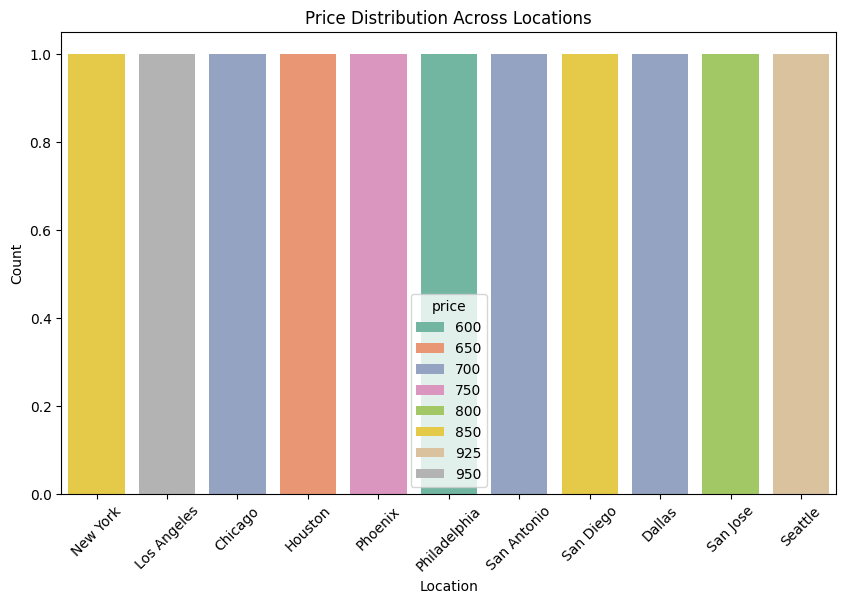

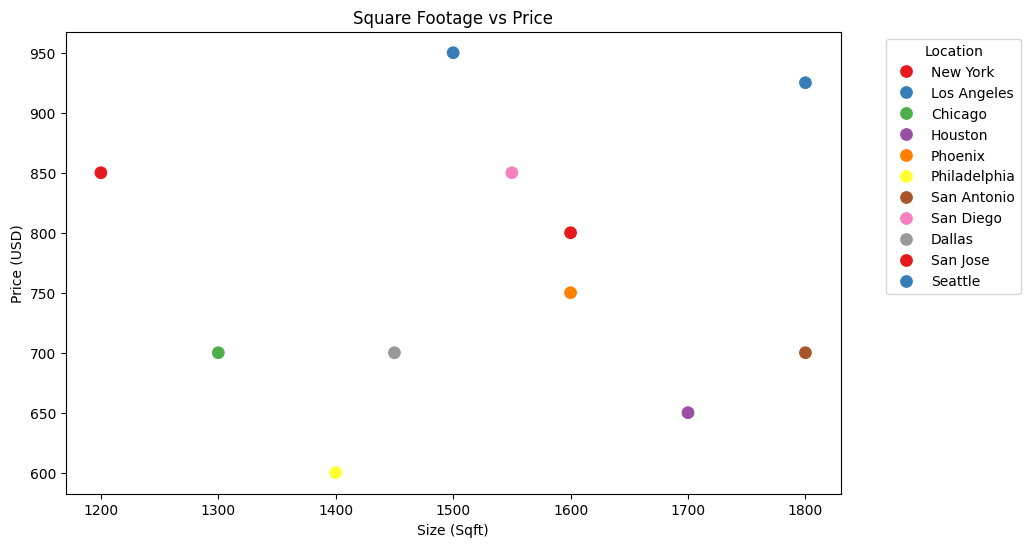

<ipython-input-8-948f061f6b73>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=examples, x="bedrooms", y="price", palette="Set1")


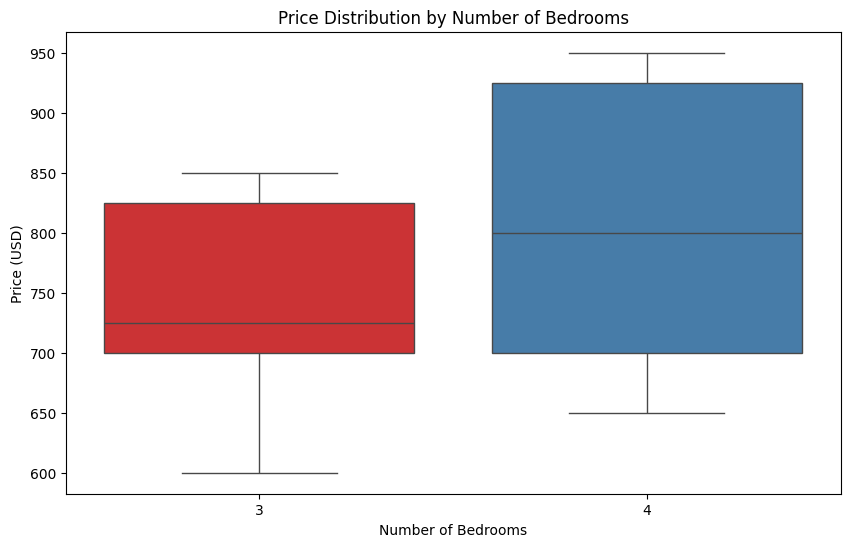

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the labeled examples (sample data) representing housing features and prices
examples = pd.DataFrame(
    [
        {"location": "New York", "size_sqft": 1200, "bedrooms": 3, "bathrooms": 2, "age": 10, "lot_size_acres": 0.15, "garage": True, "price": 850},
        {"location": "Los Angeles", "size_sqft": 1500, "bedrooms": 4, "bathrooms": 3, "age": 8, "lot_size_acres": 0.25, "garage": True, "price": 950},
        {"location": "Chicago", "size_sqft": 1300, "bedrooms": 3, "bathrooms": 2, "age": 15, "lot_size_acres": 0.2, "garage": False, "price": 700},
        {"location": "Houston", "size_sqft": 1700, "bedrooms": 4, "bathrooms": 3, "age": 5, "lot_size_acres": 0.3, "garage": True, "price": 650},
        {"location": "Phoenix", "size_sqft": 1600, "bedrooms": 3, "bathrooms": 2, "age": 7, "lot_size_acres": 0.25, "garage": True, "price": 750},
        {"location": "Philadelphia", "size_sqft": 1400, "bedrooms": 3, "bathrooms": 2, "age": 12, "lot_size_acres": 0.18, "garage": False, "price": 600},
        {"location": "San Antonio", "size_sqft": 1800, "bedrooms": 4, "bathrooms": 3, "age": 3, "lot_size_acres": 0.4, "garage": True, "price": 700},
        {"location": "San Diego", "size_sqft": 1550, "bedrooms": 3, "bathrooms": 2, "age": 9, "lot_size_acres": 0.22, "garage": True, "price": 850},
        {"location": "Dallas", "size_sqft": 1450, "bedrooms": 3, "bathrooms": 2, "age": 11, "lot_size_acres": 0.19, "garage": True, "price": 700},
        {"location": "San Jose", "size_sqft": 1600, "bedrooms": 4, "bathrooms": 3, "age": 6, "lot_size_acres": 0.2, "garage": False, "price": 800},
        {"location": "Seattle", "size_sqft": 1800, "bedrooms": 4, "bathrooms": 2, "age": 10, "lot_size_acres": 0.2, "garage": False, "price": 925},
    ]
)


# Visualization 1: Distribution of price categories across different locations
plt.figure(figsize=(10, 6))
sns.countplot(data=examples, x="location", hue="price", palette="Set2")
plt.title("Price Distribution Across Locations")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Scatter plot of size vs price for each location
plt.figure(figsize=(10, 6))
sns.scatterplot(data=examples, x="size_sqft", y="price", hue="location", palette="Set1", s=100)
plt.title("Square Footage vs Price")
plt.xlabel("Size (Sqft)")
plt.ylabel("Price (USD)")
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualization 3: Boxplot for price distribution based on the number of bedrooms
plt.figure(figsize=(10, 6))
sns.boxplot(data=examples, x="bedrooms", y="price", palette="Set1")
plt.title("Price Distribution by Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price (USD)")
plt.show()

